In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Layer
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from keras import backend as K
from keras.metrics import binary_crossentropy
from keras.callbacks import EarlyStopping
import seaborn as sns



# Variational Autoencoders
Variational autoencoders are a subtype of autoencoders. In VAEs, instead of mapping your image to a specific vector, you map it to a probability distribution. You typically assume a normal distribution and map the image to its mean and standard deviation. You then sample a vector using the distribution. Part of the loss is the K-L divergence between the standard normal distribution and the learned distribution. This forces a normal distribution. The other part of the loss is just the reconstruction loss.

Loss = reconstruction loss + KL divergence

How to sample the vector and do backprop?
Answer z = meean + sigma * std normal distribution
Note the standard normal distribution is (obviously) not learned. So you don't really have to worry about the sampling during training since only the mean and sigma are trained.

# Load Data

In [37]:
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [38]:
# Reshape data
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)

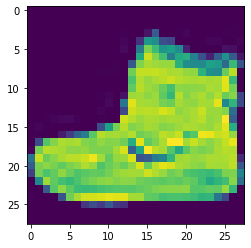

In [39]:
plt.imshow(x_train[0])
plt.show()


# Build Model

## Make the Custom Loss

In [40]:
class VAELoss(Layer):
    def vae_loss(self, x, z_decoded, z_sigma, z_mu):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss compares input and decoded image
        recon_loss = binary_crossentropy(x, z_decoded)

        # KL Divergence compares distribution to normal
        kl_div = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        return K.mean(recon_loss + kl_div)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_sigma = inputs[2]
        z_mu = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_sigma, z_mu)
        self.add_loss(loss, inputs=inputs)
        return x

## Make the Model

In [41]:
class VAE(Model):
    def __init__(self, latent_dim, input_shape):
        super(VAE, self).__init__()
        
        # Define encoder
        enc_inputs = Input(shape=input_shape)
        x = Conv2D(32, 3, padding='same', activation='relu')(enc_inputs)
        x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
        x = Conv2D(64, 3, padding='same', activation='relu')(x)
        x = Conv2D(64, 3, padding='same', activation='relu')(x)

        conv_shape = K.int_shape(x)

        x = Flatten()(x)
        x = Dense(32, activation='relu')(x)

        z_mu = Dense(latent_dim, name='latent_mu')(x)
        z_sigma = Dense(latent_dim, name='latent_sigma')(x)
        # Sampling layer
        z = Lambda(self.sample, output_shape=(latent_dim,), name='z')([z_mu, z_sigma])

        self.encoder = Model(enc_inputs, [z_mu, z_sigma, z], name='encoder')

        # Define decoder
        dec_inputs = Input(shape=(latent_dim,))

        # First get to same shape as the convoluted image in the encoder
        x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3])(dec_inputs)
        x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

        # Then apply transposed convolutions to reconstruct the image
        x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
        x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid')(x)

        decode_shape = K.int_shape(x)

        self.decoder = Model(dec_inputs, x, name='decoder')
        
        # Define model for loss calculation
        z_decoded_input = Input(shape=decode_shape[1:], name='z_decoded input')
        z_sigma_input = Input(shape=K.int_shape(z_sigma)[1:], name='z_sigma input')
        z_mu_input = Input(shape=K.int_shape(z_mu)[1:], name='z_mu input')

        loss = VAELoss()([enc_inputs, z_decoded_input, z_sigma_input, z_mu_input])

        self.loss_model = Model([enc_inputs, z_decoded_input, z_sigma_input, z_mu_input], loss, name='loss_model')

    def call(self, x):
        mu, sigma, z = self.encoder(x)
        z_decoded = self.decoder(z)
        loss = self.loss_model([x, z_decoded, sigma, mu])
        return loss

    # Sample a random vector using the learned mean and standard deviation, assuming a normal distribution
    def sample(self, args):
        z_mu, z_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
        return z_mu + K.exp(z_sigma/2) * epsilon

vae = VAE(2, x_train[0].shape)
vae.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
vae.summary()

Model: "vae_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
 loss_model (Functional)     (None, 28, 28, 1)         0         
                                                                 
Total params: 550,629
Trainable params: 550,629
Non-trainable params: 0
_________________________________________________________________


# Training
During training, the model learns parameters for a normal distribution. Specifically, the model consists of an encoder and a decoder. The encoder takes in images and transforms them into normal distribution parameters. These parameters are used to generate latent representations of the images. These representations are used by the decoder to reconstruct the image. The loss function consists of the meana of the reconstruction loss - simply the cross entropy between the real and reconstructed image - and the KL divergence between a standard normal distribution and the generated distribution.

In [42]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
vae.compile(optimizer='adam', loss=None)
vae.fit(x_train, None, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 7s 8ms/step - loss: 0.3766 - val_loss: 0.3507
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3446 - val_loss: 0.3437
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3400 - val_loss: 0.3403
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3372 - val_loss: 0.3383
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3355 - val_loss: 0.3363
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3342 - val_loss: 0.3355
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3330 - val_loss: 0.3351
Epoch 8/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3321 - val_loss: 0.3333
Epoch 9/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3312 - val_loss: 0.3327
Epoch 10/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3305 - val_loss: 0.3326

# Visualizations and Inference
The distributions of means and standard deviations generated by running test data through the encoder are below.

In [43]:
mu, sigma, z = vae.encoder(x_test)

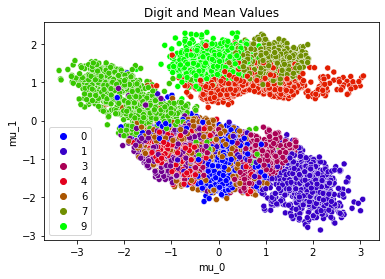

In [44]:
mu_1 = mu[:,0]
mu_2 = mu[:,1]
sns.scatterplot(x=mu_1, y=mu_2, hue=y_test, palette='brg')
plt.title('Digit and Mean Values')
plt.xlabel('mu_0')
plt.ylabel('mu_1')
plt.show()

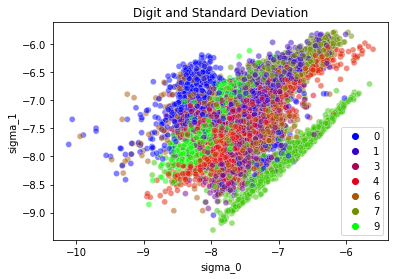

In [48]:
sigma_1 = sigma[:,0]
sigma_2 = sigma[:,1]
sns.scatterplot(x=sigma_1, y=sigma_2, hue=y_test, palette='brg', alpha=0.5)
plt.title('Digit and Standard Deviation')
plt.xlabel('sigma_0')
plt.ylabel('sigma_1')
plt.show()

In [46]:
def predictions(data, model=vae):
    _, _, z = model.encoder(data)
    z_decoded = model.decoder(z)
    return z_decoded

z_test = predictions(x_test)

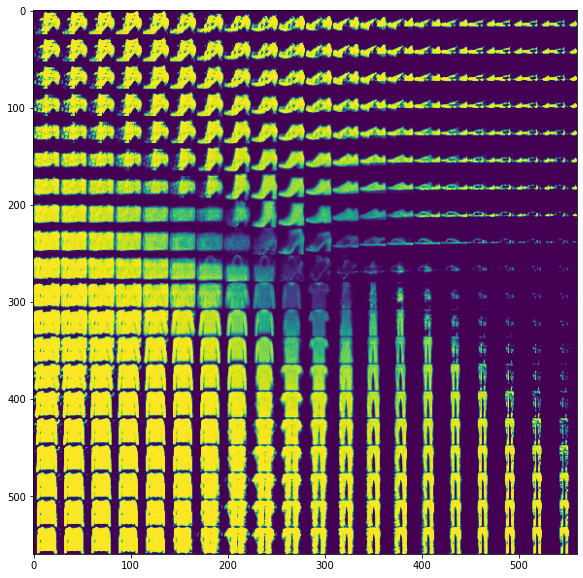

In [47]:
n_digits = 20
grid = np.zeros((img_width * n_digits, img_height*n_digits, num_channels))

# latent variable ranges, determined from the plot of means
grid_x = np.linspace(-5, 5, n_digits)
grid_y = np.linspace(-5, 5, n_digits)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        grid[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
fig_shape = np.shape(grid)
figure = grid.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure)
plt.show()  